<a href="https://colab.research.google.com/github/SeongilHeo/hufs_ai_camp/blob/master/Day7_1_cats_or_dogs_using_cnn_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 전이 학습 방식의 고양이와 개 분류 문제 (Transfer Learning)

In [ ]:
%pip install opencv-python

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install tqdm

In [ ]:
%pip install seaborn

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%matplotlib inline 

### 텐서플로와 다른 라이브러리 임포트

In [ ]:
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

import os, cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 

print(tf.__version__)

2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### GPU 메모리 설정 (프로그램에서 필요한만큼만 할당하는 방식)

In [ ]:
# 런타임에서 할당하는데 필요한 양만큼의 GPU 메모리를 할당
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

### Dogs and Cats 데이터셋 로드

Zip파일 경로

In [ ]:
PATH = '/content/drive/My Drive/data/dogs-and-cats/'

train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")

Zip파일 형태로 읽어서 zip 파일이 *있는* 디렉토리에 압축을 풀어서 사용

In [ ]:
import zipfile
import os
EXTRACT_FOLDER = os.getcwd()
TRAIN_FOLDER = os.path.join(EXTRACT_FOLDER, "train")
TEST_FOLDER =  os.path.join(EXTRACT_FOLDER, "test")

# Train 이미지
if os.path.exists(TRAIN_FOLDER) is False:
  with zipfile.ZipFile(train_image_path,"r") as z:
      z.extractall(EXTRACT_FOLDER)

# Test 이미지
if os.path.exists(TEST_FOLDER) is False:
  with zipfile.ZipFile(test_image_path,"r") as z:
      z.extractall(EXTRACT_FOLDER)

이미지 파일이름을 목록으로 읽기 (단, Train 이미지는 2만개만 읽음)

In [ ]:
SAMPLE_SIZE = 20000
train_image_list = os.listdir(TRAIN_FOLDER)[0:SAMPLE_SIZE]
test_image_list = os.listdir(TEST_FOLDER)

#### 레이블 생성 
파일 이름이 cat으로 시작하면 0, dog로 시작하면 1 
ex) 훈련 파일 : cat.100.jpg

In [ ]:
def make_image_label(filename):
    pet = filename.split('.')[-3]
    if pet == 'cat': return 0
    elif pet == 'dog': return 1

이미지 파일로부터 데이터셋 생성
1. 레이블 생성
* 훈련 파일 이름 :  'cat.0.jpg'
* 테스트 파일 이름 : '101.jpg'
2. 이미지 읽기 (읽어서 크기 변환)



In [ ]:
IMG_SIZE = 160

def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []  # 데이터 목록 [image, label] 리스트
    for filename in tqdm(data_image_list):      # tqdm으로 Progress Bar 표시
        if(isTrain):
            label = make_image_label(filename)  # train label 생성
        else:
            label = filename.split('.')[0]

        path = os.path.join(DATA_FOLDER,filename)
        img = cv2.imread(path,cv2.IMREAD_COLOR)     # 이미지 읽기
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))  # 이미지 resize (160, 160)
        data_df.append([np.array(img),np.array(label)])

    shuffle(data_df)  # 데이터 섞기
    return data_df

##### 클래스 분포 확인

In [ ]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3]) # cat과 dog 분리
    sns.countplot(labels)   # 같은 값의 개수를 세어서 bar 그래프로 그리기
    plt.title('Cats and Dogs')

#### 생성된 훈련 데이터셋의 클래스 분포

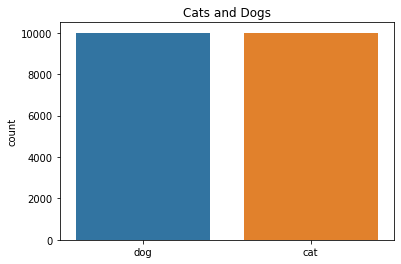

In [ ]:
plot_image_list_count(train_image_list)

Let's show also the class distribution in the full train data set.

####  훈련 이미지 폴더에 있는 이미지 파일의 클래스 분포

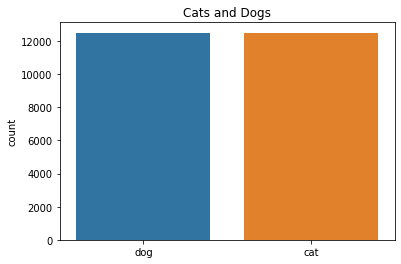

In [ ]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))

#### 훈련 데이터 로드
훈련 데이터와 테스트 데이터 이미지 파일을 읽으면서 레이블 생성


In [ ]:
train = process_data(train_image_list, TRAIN_FOLDER)
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 12500/12500 [00:34<00:00, 362.60it/s]


#### 이미지를 5x5 그리드로 그리기

In [ ]:
def show_images(data, isTest=False):
    figs, ax = plt.subplots(5,5, figsize=(15,15)) # ax는 Array of axes
    for i, img in enumerate(data[:25]):
        img_data = img[0] # 이미지 데이터
        label = img[1]    # 이미지 레이블
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if isTest:
            str_label='None'
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

#### 훈련 이미지 확인

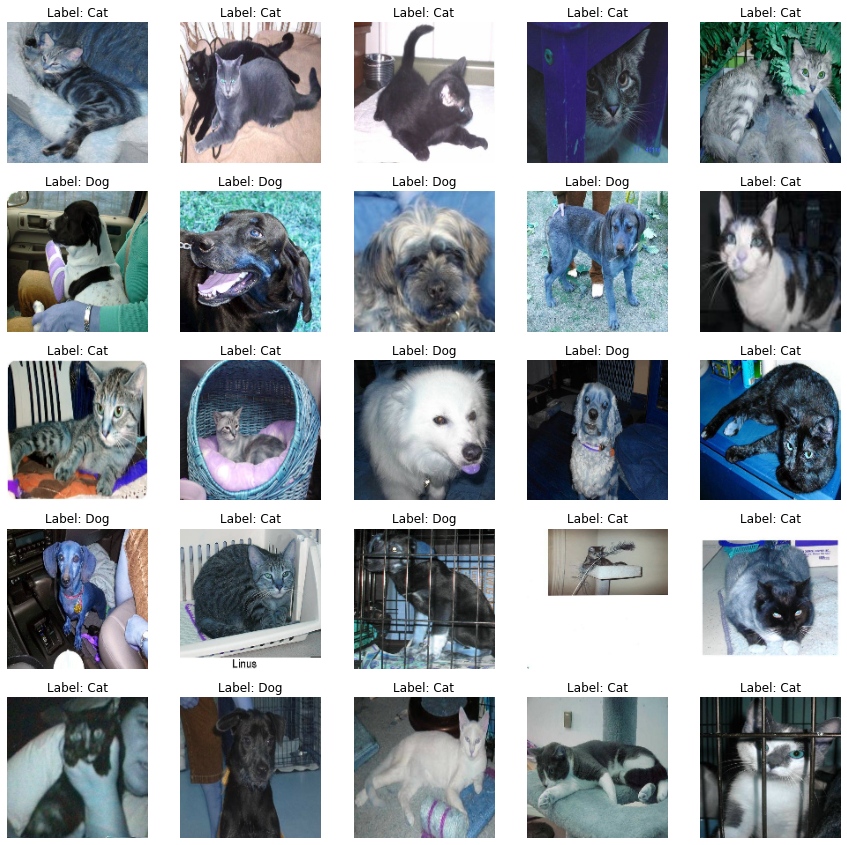

In [ ]:
show_images(train)

#### 테스트 이미지 확인

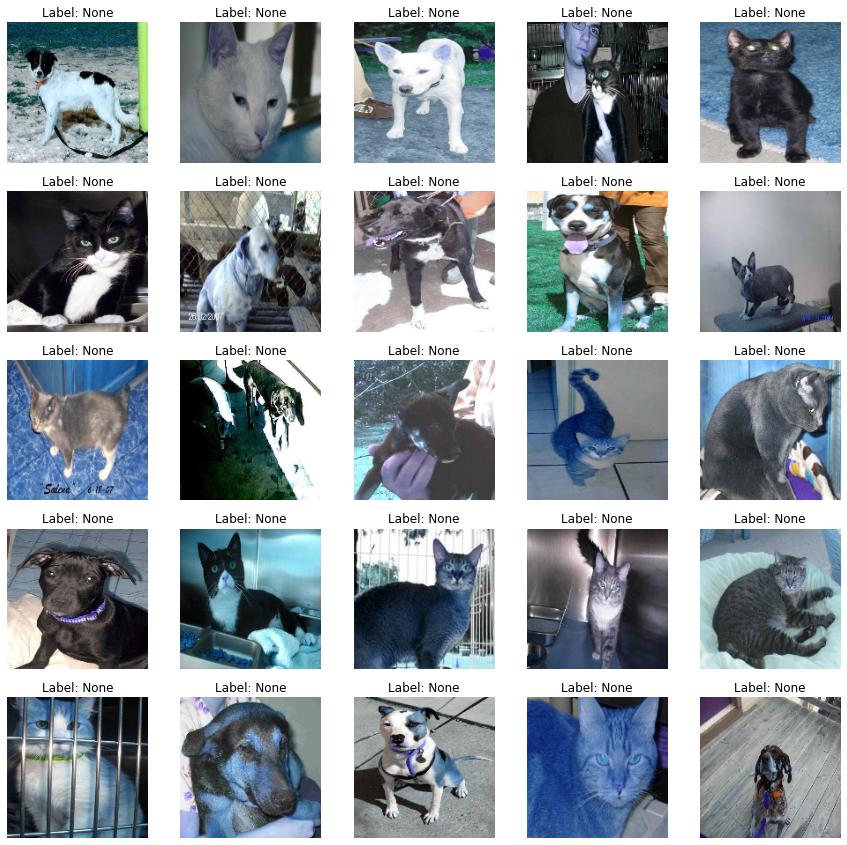

In [ ]:
show_images(test,True)

#### 훈련 데이터셋 (Numpy)

In [ ]:
train_images = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
train_labels = np.array([i[1] for i in train])

#### 테스트 데이터셋 (Numpy)

In [ ]:
test_images = np.array([i[0] for i in test])
test_labels = np.array([i[1] for i in test])

### 훈련 데이터에서 검증 데이터 분리

In [ ]:
VALIDATION_SIZE = 0.2
RANDOM_STATE = 2020
train_images, valid_images, train_labels, valid_labels = \
  train_test_split(train_images, train_labels, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

## 모델 정의

#### Pre-trained된 ResNet50을 기본 모델로 생성

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model ResNet50
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            pooling='max',
                                            weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


모델이 학습되지 않도록 trainable을 False로 설정

In [ ]:
base_model.trainable = False
len(base_model.trainable_variables)

0

ResNet50 모델 확인

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### 모델 생성

In [ ]:
NUM_CLASSES = 2

model = keras.Sequential([
        base_model, 
        keras.layers.Dense(NUM_CLASSES, activation='softmax'),
        ])

len(model.trainable_variables)

2

#### 모델 구조 확인

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


### 모델 컴파일

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.Adam(lr=base_learning_rate), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#### 초기 성능 확인
Fineturning하기 전 정확도가 28%대 라는 것을 확인한다.

In [ ]:
validation_steps = 20
loss0,accuracy0 = model.evaluate(valid_images, valid_labels, steps = validation_steps)

20/20 [==============================] - 12s 587ms/step - loss: 3.0069 - accuracy: 0.5280


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.01
initial accuracy: 0.53


## 모델 훈련

In [ ]:
BATCH_SIZE = 32
initial_epochs = 10

history = model.fit(train_images, train_labels,
                  epochs=initial_epochs,
                  verbose=1,
                  validation_data=(valid_images, valid_labels))

Epoch 1/10
500/500 [==============================] - 72s 144ms/step - loss: 0.4992 - accuracy: 0.9036 - val_loss: 0.2420 - val_accuracy: 0.9510
Epoch 2/10
500/500 [==============================] - 71s 143ms/step - loss: 0.2295 - accuracy: 0.9542 - val_loss: 0.2006 - val_accuracy: 0.9600
Epoch 3/10
500/500 [==============================] - 71s 143ms/step - loss: 0.1863 - accuracy: 0.9617 - val_loss: 0.1867 - val_accuracy: 0.9630
Epoch 4/10
500/500 [==============================] - 71s 143ms/step - loss: 0.1573 - accuracy: 0.9643 - val_loss: 0.1846 - val_accuracy: 0.9632
Epoch 5/10
500/500 [==============================] - 71s 143ms/step - loss: 0.1405 - accuracy: 0.9668 - val_loss: 0.1948 - val_accuracy: 0.9645
Epoch 6/10
500/500 [==============================] - 71s 143ms/step - loss: 0.1237 - accuracy: 0.9704 - val_loss: 0.1680 - val_accuracy: 0.9657
Epoch 7/10
500/500 [==============================] - 71s 143ms/step - loss: 0.1099 - accuracy: 0.9716 - val_loss: 0.1649 - val_ac

#### 성능 그래프

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

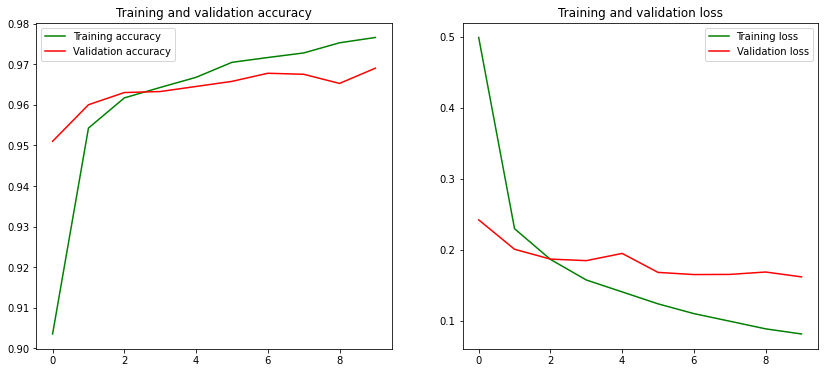

In [ ]:
plot_accuracy_and_loss(history)

### 성능 검증
Finetuning 후 정확도가 96%대라는 것을 확인한다.

In [ ]:
score = model.evaluate(valid_images, valid_labels, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.16169671714305878
Validation accuracy: 0.968999981880188


#### 클래스 별 정확도 분석

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(valid_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


#### 검증 데이터의 분류 성능 리포트

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(valid_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.97      0.97      0.97      2034
    Class 1:       0.97      0.97      0.97      1966

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



## Fine tuning

베이스 모델을 학습 가능하게 변경

In [ ]:
base_model.trainable = True
len(base_model.trainable_variables)

212

In [ ]:
len(base_model.layers)

176

100번째 계층 이후로 unfreezing

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

len(base_model.trainable_variables)

Number of layers in the base model:  176


90

#### 모델 컴파일
학습률을 1/10로 줄여서 실행

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(lr=base_learning_rate/10), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#### 모델 구조 확인

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 19,457,026
Non-trainable params: 4,134,784
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

92

#### 모델 훈련

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_images, train_labels,
                         epochs=total_epochs,
                         verbose=1,
                         initial_epoch =  history.epoch[-1]+1,
                         validation_data=(valid_images, valid_labels))

Epoch 11/15
500/500 [==============================] - 119s 239ms/step - loss: 0.1926 - accuracy: 0.9471 - val_loss: 0.1592 - val_accuracy: 0.9620
Epoch 12/15
500/500 [==============================] - 119s 238ms/step - loss: 0.0306 - accuracy: 0.9889 - val_loss: 0.1507 - val_accuracy: 0.9653
Epoch 13/15
500/500 [==============================] - 119s 238ms/step - loss: 0.0144 - accuracy: 0.9956 - val_loss: 0.1463 - val_accuracy: 0.9655
Epoch 14/15
500/500 [==============================] - 119s 239ms/step - loss: 0.0079 - accuracy: 0.9970 - val_loss: 0.1470 - val_accuracy: 0.9660
Epoch 15/15
500/500 [==============================] - 119s 238ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.1503 - val_accuracy: 0.9668


####  성능 확인

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy']+ history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

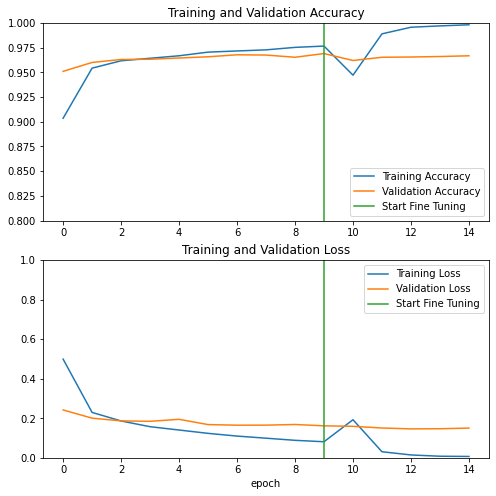

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 테스트

배열 형태로 예측 결과 확인

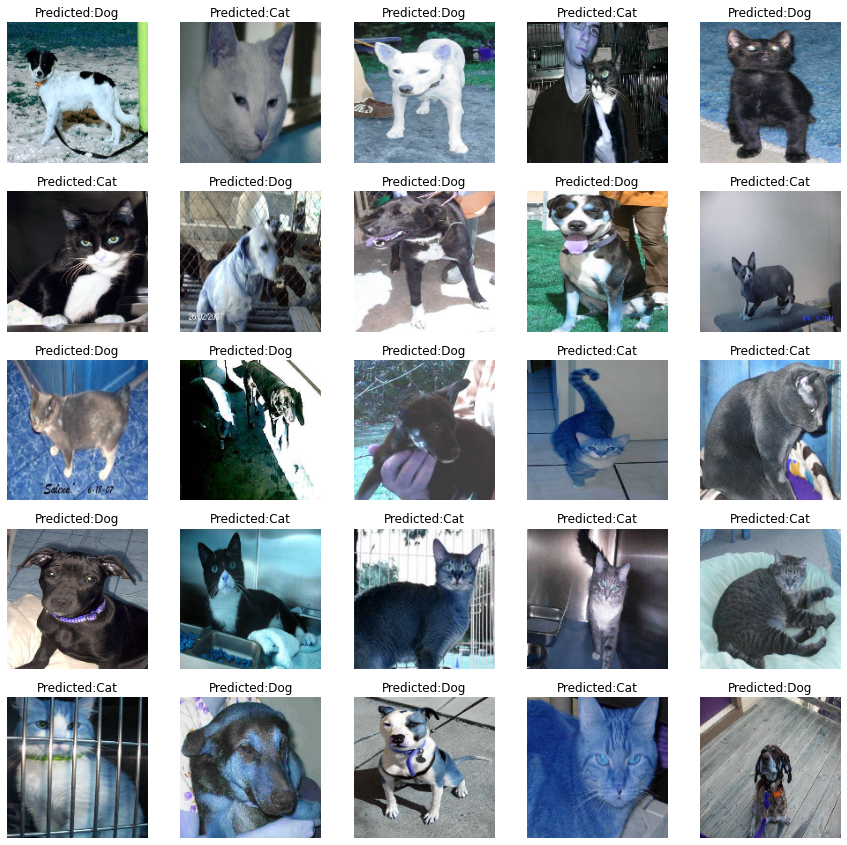

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()